In [1]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
# sns.set(font='SimHei', font_scale=2.5)
plt.rcParams['axes.grid'] = True

import numpy as np
import pandas as pd

np.random.seed(0)

import logging
logging.basicConfig()
logger = logging.getLogger(__name__)

from IPython.display import Image

Chapter 2: Multi-armed Bandits
==============


### 2.1 A k-armed Bandit Problem

nonassociative, evaluative feedback problem:

reward = sample(P(action))
+ P(action) is a **stationary** probability distribution.
+ reward: $R$
+ $k$ different actions $a$.
+ goal: maximize the expected total reward over some time period.

The value $q$ of $a$ is the expected reward:

\begin{align}
    q(a) &= \mathbb{E} \left [ R_t \mid A_t = a \right ] \\
         &\approx \frac1{N} \sum_t^N R_t \mid A_t = a \quad \text{law of large numbers} \\
         &= Q_t(a)
\end{align}

### 2.2 Action-value Methods

one natural way to estimate the value of $a$ is by averaging the rewards actually received: (sample-average method)
\begin{equation}
    Q_t(a) = \frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}(A_i = a)}{\sum_{i=1}^{t-1} \cdot \mathbb{1}(A_i = a)}
\end{equation}

strategies:
+ greedy action: $A_t = \operatorname{argmax}_a Q_t(a)$
+ $\epsilon$-greedy actions:

\begin{equation}
    A_t =
    \begin{cases}
        \operatorname{argmax}_a Q_t(a) & \quad \text{ with probability 1 - $\epsilon$} \\
        \text{a random action} & \quad \text{ with probability $\epsilon$}
    \end{cases}
\end{equation}

##### Exercise
2.1:

$0.5 * 1 + 0.5 * 1/2 = 0.75$


2.2: 

+ definitely occur: steps = 2, 5
+ possiblly occur: steps= 1, 3, 4

### 2.3 The 10-armed Testbed

In [16]:
reward_funcs = [
    lambda size: np.random.normal(0.2, 1, size),
    lambda size: np.random.normal(-0.8, 1, size),
    lambda size: np.random.normal(1.5, 1, size),
    lambda size: np.random.normal(0.4, 1, size),
    lambda size: np.random.normal(1.2, 1, size),
    lambda size: np.random.normal(-1.3, 1, size),
    lambda size: np.random.normal(-0.2, 1, size),
    lambda size: np.random.normal(-1.0, 1, size),
    lambda size: np.random.normal(1.0, 1, size),
    lambda size: np.random.normal(-0.4, 1, size),
]

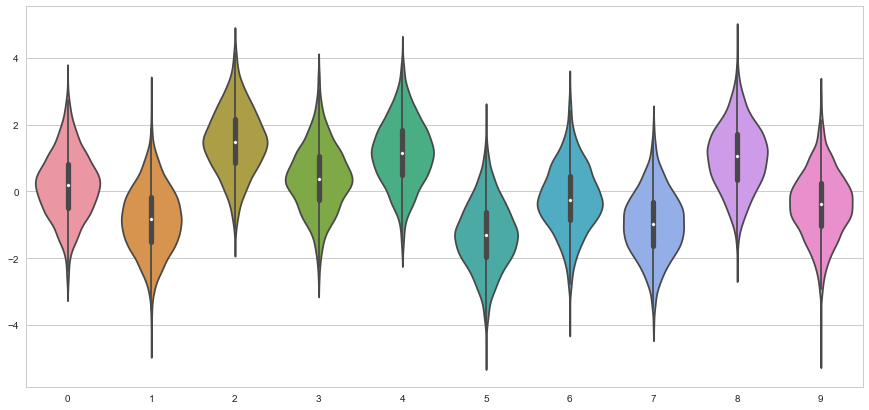

In [17]:
examples = pd.DataFrame([func(2000) for func in reward_funcs]).T
examples.index.name = "Reward distribution"
plt.figure(figsize=(15, 7))
sns.violinplot(data=examples)
del examples

In [18]:
class GreedyAction(object):
    def __init__(self, k, varepsilon=0):
        self.varepsilon = varepsilon
        self.k = k
        # sum of rewards, number of action
        self._records = np.zeros((k, 2))
    
    def _Q_t(self):
        r = self._records[:, 0]
        n = self._records[:, 1]
        res = np.divide(r, n, out=np.zeros_like(r), where=n!=0)
        logger.info("Q_t: {}".format(res))
        return res
    
    def action(self):
        if np.random.random() < self.varepsilon:
            a = np.random.randint(low=0, high=self.k)
            logger.info("random action: {}".format(a))
            return a
        else:
            a = np.argmax(self._Q_t())
            logger.info("greedy action: {}".format(a))
            return a
    
    def update_reward(self, action, reward):
        self._records[action, 0] += reward
        self._records[action, 1] += 1
        
        
class Environment(object):
    def __init__(self, reward_funcs):
        self.reward_funcs = reward_funcs
        self.k = len(reward_funcs)
       
    def feedback(self, action):
        assert 0 <= action < self.k, "action: {} must be in [0, {}]".format(action, self.k)
        return self.reward_funcs[action](1)[0]

In [19]:
def run_10_armed(varepsilon):
    opt_action = 2
    env = Environment(reward_funcs)
    actioner = GreedyAction(env.k, varepsilon)
    step_records = []
    
    def step():
        history = []
        for _ in range(100):
            a = actioner.action()
            r = env.feedback(a)
            actioner.update_reward(a, r)
            logger.info("action: {}, reward: {}".format(a, r))
            history.append([a, r])
        history = np.array(history)
        return np.sum(history[:, 0] == opt_action), np.sum(history[:, 1]), history.shape[0] 
    
    for _ in range(100):
        step_records.append(step())
    
    result = pd.DataFrame(step_records, columns=["opt_actions", "total_rewards", "iterate_nums"])
    result = result.cumsum()
    result["opt_actions_rate"] = result["opt_actions"] / result["iterate_nums"]
    result["average_rewards"] = result["total_rewards"] / result["iterate_nums"]
    # return result[["opt_actions_rate", "average_rewards"]]
    return result

In [20]:
logger.setLevel(logging.WARNING)

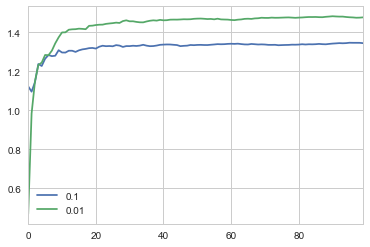

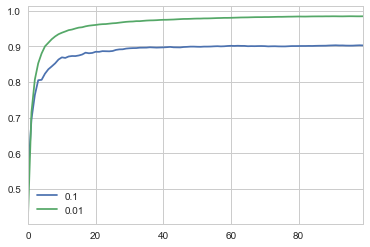

In [29]:
dfs = [run_10_armed(v) for v in [0.1, 0.01]]
results = pd.concat(dfs, keys=['0.1', '0.01'], axis=1).swaplevel(0, 1, axis=1)
results["average_rewards"].plot()
results["opt_actions_rate"].plot()

实验结果和书中有出入

### 2.4 Incremental Implementation

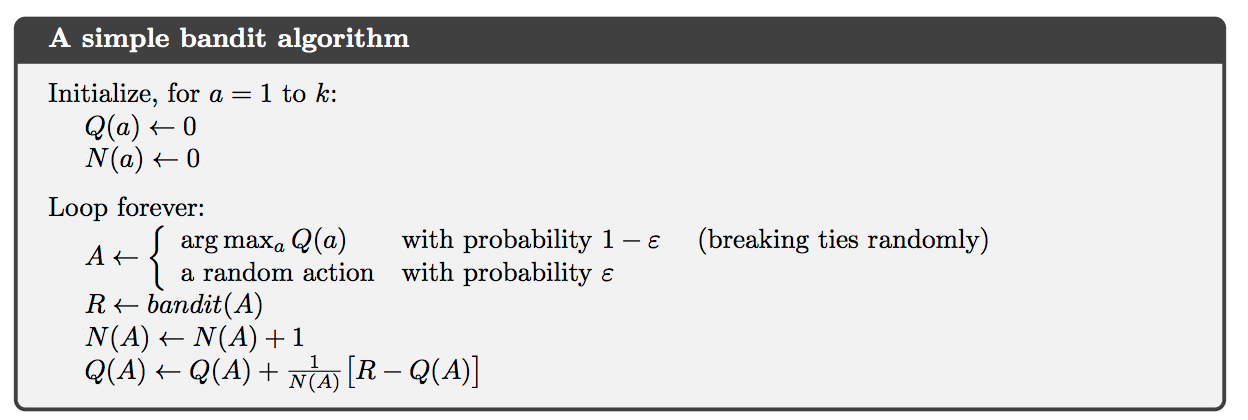

In [4]:
Image('./res/fig_simple.png')

General form:

\begin{equation}
    \text{NewEstimate} \leftarrow \text{OldEstimate} + \text{StepSize} \left [ \text{Target} - \text{OldEstimate} \right ]
\end{equation}

### 2.5 Tracking a Nonstationary Problem

it makes sense to give more weight to recent rewards than to long-past rewards: $Q_{n+1} = \alpha R_n + (1 - \alpha) Q_n$ (exponential recency-weighted average)

the conditions required to assure convergence with probability 1:

\begin{align}
    \sum_{n=1}^\infty \alpha_n(a) &= \infty &
    \sum_{n=1}^\infty \alpha_n^2(a) &< \infty &
\end{align}

exercise 2.5:

In [34]:
class NonstationaryEnvironment(object):
    def __init__(self, reward_funcs):
        self.reward_funcs = reward_funcs
        self.k = len(reward_funcs)
        
        self.iteration = 0
       
    def feedback(self, action):
        assert 0 <= action < self.k, "action: {} must be in [0, {}]".format(action, self.k)
        self.iteration += 1
        return self.reward_funcs[action](1)[0] + np.random.normal(0, self.iteration / 100, 1)[0]

In [35]:
def run_nonstationary_10_armed(varepsilon):
    env = NonstationaryEnvironment(reward_funcs)
    actioner = GreedyAction(env.k, varepsilon)
    step_records = []
    
    def step():
        history = []
        for _ in range(100):
            a = actioner.action()
            r = env.feedback(a)
            actioner.update_reward(a, r)
            logger.info("action: {}, reward: {}".format(a, r))
            history.append([a, r])
        history = np.array(history)
        return np.sum(history[:, 1]), history.shape[0] 
    
    for _ in range(100):
        step_records.append(step())
    
    result = pd.DataFrame(step_records, columns=["total_rewards", "iterate_nums"])
    result = result.cumsum()
    result["average_rewards"] = result["total_rewards"] / result["iterate_nums"]
    return result

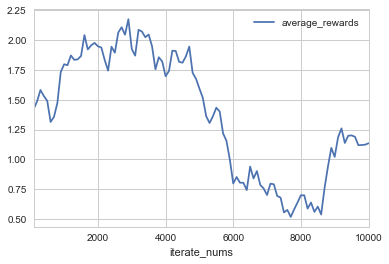

In [38]:
run_nonstationary_10_armed(0.01).plot(x='iterate_nums', y='average_rewards')

In [39]:
class ExpGreedyAction(object):
    def __init__(self, k, varepsilon=0, alpha=0.1):
        self.varepsilon = varepsilon
        self.alpha = alpha
        self.k = k
        # sum of rewards, number of action
        self._records = np.zeros((k, 2))
    
    def _Q_t(self):
        return self._records[:, 0]
    
    def action(self):
        if np.random.random() < self.varepsilon:
            a = np.random.randint(low=0, high=self.k)
            logger.info("random action: {}".format(a))
            return a
        else:
            a = np.argmax(self._Q_t())
            logger.info("greedy action: {}".format(a))
            return a
    
    def update_reward(self, action, reward):
        self._records[action, 1] += 1
        self._records[action, 0] += self.alpha * (reward - self._records[action, 0]) / self._records[action, 1]

In [40]:
def run_exp_10_armed(varepsilon, alpha):
    env = NonstationaryEnvironment(reward_funcs)
    actioner = ExpGreedyAction(env.k, varepsilon, alpha)
    step_records = []
    
    def step():
        history = []
        for _ in range(100):
            a = actioner.action()
            r = env.feedback(a)
            actioner.update_reward(a, r)
            logger.info("action: {}, reward: {}".format(a, r))
            history.append([a, r])
        history = np.array(history)
        return np.sum(history[:, 1]), history.shape[0] 
    
    for _ in range(100):
        step_records.append(step())
    
    result = pd.DataFrame(step_records, columns=["total_rewards", "iterate_nums"])
    result = result.cumsum()
    result["average_rewards"] = result["total_rewards"] / result["iterate_nums"]
    return result

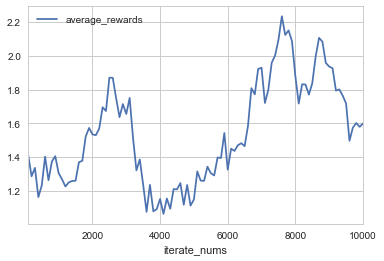

In [45]:
run_exp_10_armed(0.1, 0.1).plot(x='iterate_nums', y='average_rewards')

### 2.6 Optimistic Initial Values

All the methods we have discussed are biased by their initial estimates.

如2.6式红色部份：

\begin{equation}
    Q_{n+1} = \color{red}{(1 - \alpha)^n Q_1} + \sum_{i=1}^n \alpha (1 - \alpha)^{n-1} R_i
\end{equation}

We call this technique for encouraging exploration optimistic initial values: say, using $Q_1(a) = 5$.

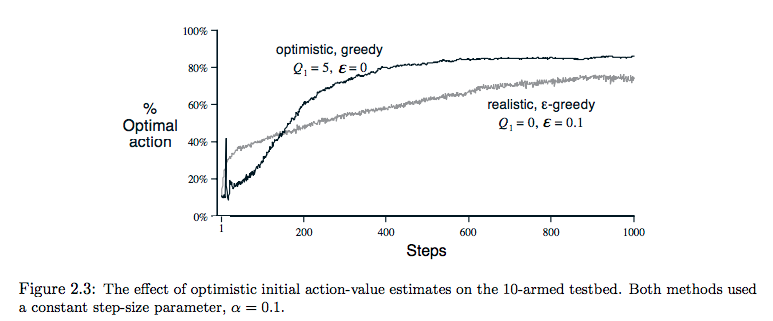

In [5]:
Image('./res/fig2_3.png')

Exercise 2.6: 前期有大量探索，所以开始表现不好

Exercise 2.7:

首先归纳：

\begin{align*}
    O_{t+1} &= O_t + \alpha (1 - O_t) \\
            &= \alpha + (1 - \alpha) O_t \\
            &= \alpha + (1 - \alpha) (\alpha + (1 - \alpha) O_{t-1} ) \\
            &= \alpha + (1 - \alpha) \alpha + (1 - \alpha)^2 O_{t-1} \\
            &= \alpha + (1 - \alpha) \alpha + (1 - \alpha)^2 \alpha + \cdots + (1 - \alpha)^{t} O_{t-(t-1)} \\
            &= \alpha + (1 - \alpha) \alpha + (1 - \alpha)^2 \alpha + \cdots + (1 - \alpha)^{t} O_1 \\
            &= \alpha + (1 - \alpha) \alpha + (1 - \alpha)^2 \alpha + \cdots + (1 - \alpha)^{t} \alpha \\
            &= \alpha (1 + (1 - \alpha) + (1 - \alpha)^2 + \cdots + (1 - \alpha)^{t}) \\
            &= \alpha (1 + \sum_{k=1}^{t}(1 - \alpha)^k ) \\
\end{align*}

得到$\beta_n = \frac{\alpha}{O_n} = \frac1{1 + \sum_{t=1}^{n-1} (1 - \alpha)^t}$

且：
\begin{align}
    (1 - \beta_n) \beta_{n-1} &= \beta_n (\frac1{\beta_n} - 1) \beta_{n-1} \\
                              &= \beta_n \frac{\sum_{t=1}^{n-1}}{1 + \sum_{t=1}^{n-2}} \\
                              &= \beta_n \frac{(1 - \alpha) \left (1 + \sum_{t=1}^{n-2} \right )}{1 + \sum_{t=1}^{n-2}} \\
                              &= \beta_n (1 - \alpha)
\end{align}

然后，利用2.5式：

\begin{align*}
    Q_{n+1} &= Q_n + \beta_n (R_n - Q_n) \\
            &= \beta_n R_n + (1 - \beta_n) Q_n \\
            &= \beta_n R_n + (1 - \beta_n) \left ( \beta_{n-1} R_{n-1} + (1 - \beta_{n-1}) Q_{n-1} \right ) \\
            &= \beta_n R_n + \color{blue}{(1 - \beta_n) \beta_{n-1}} R_{n-1} + (1 - \beta_n)(1 - \beta_{n-1}) Q_{n-1} \\
            &= \beta_n R_n + \color{blue}{\beta_n (1 - \alpha)} R_{n-1} + (1 - \beta_n)(1 - \beta_{n-1}) Q_{n-1} \\
            &= \beta_n \left ( R_n + (1 - \alpha) R_{n-1} \right ) + (1 - \beta_n)(1 - \beta_{n-1}) Q_{n-1} \\
            &= \beta_n \left ( R_n + (1 - \alpha) R_{n-1} \right ) + (1 - \beta_n)(1 - \beta_{n-1}) \left ( \beta_{n-2} R_{n-2} + (1 - \beta_{n-2}) Q_{n-2} \right ) \\
            &= \beta_n \left ( R_n + (1 - \alpha) R_{n-1} \right ) + \color{blue}{(1 - \beta_n)(1 - \beta_{n-1}) \beta_{n-2}} R_{n-2} + \prod_{t=0}^2 (1 - \beta_{n-t}) Q_{n-2} \\
            &= \beta_n \left ( R_n + (1 - \alpha) R_{n-1} \right ) + \color{blue}{\beta_n (1 - \alpha)^2} R_{n-2} + \prod_{t=0}^2 (1 - \beta_{n-t}) Q_{n-2} \\
            &= \beta_n \left ( R_n + (1 - \alpha) R_{n-1} + (1 - \alpha)^2 R_{n-2} \right ) + \prod_{t=0}^2 (1 - \beta_{n-t}) Q_{n-2} \\
            &= \beta_n \sum_{t=0}^{2} (1 - \alpha)^t R_{n-t} + \prod_{t=0}^2 (1 - \beta_{n-t}) Q_{n-2} \\
            &= \beta_n \sum_{t=0}^{n-1} (1 - \alpha)^t R_{n-t} + \prod_{t=0}^{n-1} (1 - \beta_{n-t}) Q_{n-(n-1)} \\
            &= \beta_n \sum_{t=0}^{n-1} (1 - \alpha)^t R_{n-t} + \prod_{t=0}^{n-1} (1 - \beta_{n-t}) Q_1 \\
            &= \beta_n \sum_{t=0}^{n-1} (1 - \alpha)^t R_{n-t} + \prod_{t=0}^{n-2} (1 - \beta_{n-t}) \color{red}{(1 - \beta_1)} Q_1 \\
            & \text{因为 $1 - \beta_1 = 1 - 1 = 0$} \\
            &= \beta_n \sum_{t=0}^{n-1} (1 - \alpha)^t R_{n-t} \\
            &= \frac{\sum_{t=0}^{n-1} (1 - \alpha)^t R_{n-t}}{1 + \sum_{t=1}^{n-1} (1 - \alpha)^t} \\
            &= \frac{\sum_{t=0}^{n-1} (1 - \alpha)^t R_{n-t}}{\sum_{t=0}^{n-1} (1 - \alpha)^t} \\
\end{align*}

可以看到，$Q_{n+1}$式中去除了$Q_1$影响，且各项系数累加等于1。故无偏得证。

### 2.7 Upper-Confidence-Bound Action Selection

Select among the non-greedy actions according to their potential for actually being optimal:

\begin{equation}
    A_t \doteq \operatorname{argmax}_a \left [ Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}} \right ]
\end{equation}

The square-root term: measure of the uncertainty (or variance) in the estimator of $a$'s value.

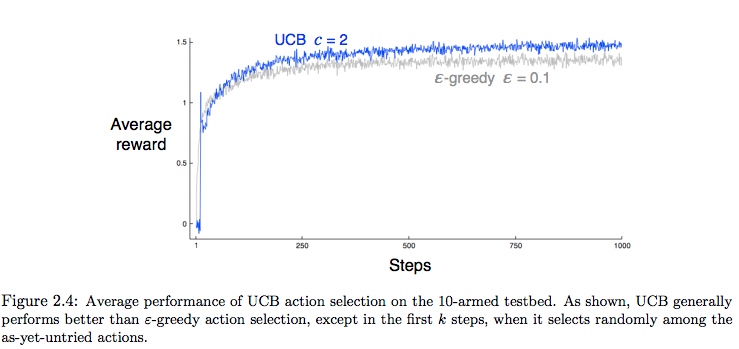

In [2]:
Image('res/fig2_4.png')

### 2.8 Gradient Bandit Algorithms

Learning a numerical *preference* $H_t(a)$ for each action.

Only the relative preference of one action over another is important, and the action probabilities are determined according to a *soft-max distribution*:

\begin{equation}
    \operatorname{Pr}\{A_t = a\} \doteq \frac{e^{H_t(a)}}{\sum_{b=1}^k e_{H_t(b)}} = \pi_t(a)
\end{equation}

update policy is based on the idea of stochastic gradient ascent:

\begin{align*}
    H_{t+1}(A_t) & \doteq H_t(A_t) + \alpha (R_t - \bar{R}_t) (1 - \pi_t(A_t)) & \text{ and } \\
    H_{t+1}(a) & \doteq H_t(a) - \alpha (R_t - \bar{R}_t) \pi_t(a) & \text{ for all $a \neq A_t$ } \\
\end{align*}

$\bar{R}_t$ is the average of all the rewards up through, which serves as a baseline.

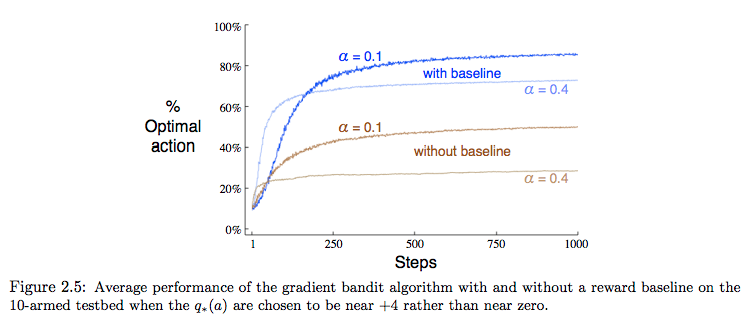

In [3]:
Image('res/fig2_5.png')

### 2.9 Associative Search (Contextual Bandits)

+ nonassociative task: stationary task. 没有场景
+ associative task: the goal is to learn a policy: a mapping from situations to the actions that are best in those situations. 有场景的区分
+ full reinforcement learning problem: action are allowed to effec the *next situation* as well as the reward. 行为可以影响场景。


Exercise 2.10:

+ cannot tell which case: 0.5 (random)
+ can tell: A - 2, B - 1: 0.55

### 2.10 Summary

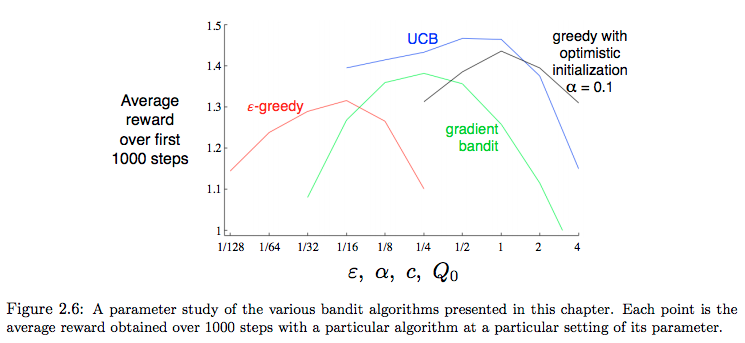

In [4]:
Image('res/fig2_6.png')